In [3]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from smoothen import scipy_get_pr
import repl_analysis
from test_to_bw_fast import get_config, get_vals_per_range



import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
run_dirs = ['/home/shush/profile/QuantPred/wandb/run-20210729_110608-rnil3owe',
            'run-20210728_102932-z4wk24jl']
# one_bed = '/home/shush/profile/QuantPred/wandb/run-20210729_110608-rnil3owe/bigwigs/7_GM12878/GM12878_truth_1_raw.bed'

In [146]:
def get_corr_dfs_and_plots(run_dir, set_type='raw', bigwig_subdir='bigwigs', corr_subdir='plots_and_tables'):
    config = get_config(run_dir)
    bin_size = config['bin_size']['value']
    
    model_id = '_'.join([str(config[x]['value']) for x in ['model_fn', 'bin_size', 'loss_fn']])
    print(model_id)
    corr_dir = util.make_dir(os.path.join(run_dir, corr_subdir))
    bw_dir = os.path.join(run_dir, bigwig_subdir)
    assert os.path.isdir(bw_dir), 'bigwig directory not found!'
    a_cell_dir = [os.path.join(bw_dir, d) for d in os.listdir(bw_dir) if os.path.isdir(os.path.join(bw_dir, d))][0]
    one_bed = [os.path.join(a_cell_dir, f) for f in os.listdir(a_cell_dir) if '_{}.bed'.format(set_type) in f][0]
    cell_line_dirs = [os.path.join(bw_dir, c) for c in os.listdir(bw_dir)]
    corr_dfs = {}
    for bw_source in ['pred', 'truth']:
        csv_filepath = os.path.join(corr_dir, 'correlation_matrix_{}_{}_{}.csv'.format(bw_source, bin_size, set_type))
        all_cov_values = []
        for cell_line_dir in cell_line_dirs:
            bw_path = [os.path.join(cell_line_dir, f) for f in os.listdir(cell_line_dir) if '{}_{}_{}.bw'.format(bw_source, bin_size, set_type) in f]
            assert len(bw_path) == 1, 'bad bws in {}, {}!'.format(bw_source, cell_line_dir)
            bw_path = bw_path[0]
            vals = get_mean_per_range(bw_path, one_bed)
            all_cov_values.append([v  for v_sub in vals for v in v_sub])
        np_cov_values = np.array(all_cov_values).T
        corr_df = pd.DataFrame(np_cov_values).corr()
        cell_line_names = [os.path.basename(cell_line_dir).split('_')[1] for cell_line_dir in cell_line_dirs]
        corr_df.columns = cell_line_names 
        corr_df['cell_lines'] = cell_line_names
        corr_df.set_index('cell_lines', inplace=True)
        corr_dfs[bw_source] = corr_df
        corr_df.to_csv(csv_filepath)
    # plot correlation matrices
    plot_corr_matrices(corr_dfs, model_id, set_type, corr_dir)
    scatter_cell_line_prs(corr_dfs, model_id, set_type, corr_dir)
    return corr_dfs, model_id

In [143]:
def scatter_cell_line_prs(corr_dfs, model_id, set_type, outdir):
    melted_corrs = {}
    for bw_set in ['truth', 'pred']:    
        df = corr_dfs[bw_set]
        np.tril(np.ones(df.shape)).astype(np.bool)
        df_lt = df.where(~np.tril(np.ones(df.shape)).astype(np.bool))
        df_lt = df_lt.stack().reset_index()
        df_lt.columns = ['cell_line1', 'cell_line2' ,'pearson\'s r']
        melted_corrs[bw_set] = df_lt
    avg_df = melted_corrs['truth'].merge(melted_corrs['pred'], on=['cell_line1', 'cell_line2'], suffixes=[' true', ' pred'])
    avg_df.to_csv(os.path.join(outdir, 'correlation_scatterplot_{}_{}.csv'.format(set_type, model_id)))
    ax = sns.scatterplot(data=corr_df, x='pearson\'s r true', y='pearson\'s r pred')
    x = [i/10 for i in range(2, 11)]
    plt.plot(x, x, 'r--')
    ax.set_aspect(1./ax.get_data_ratio())
    plt.savefig(os.path.join(outdir, 'correlation_scatterplot_{}_{}.svg'.format(set_type, model_id)))

In [141]:
def plot_corr_matrices(corr_dfs, model_id, set_type, outdir):    
    fig, axs = plt.subplots(1, 2, figsize=[20, 8])
    min_lim = pd.concat([v for _, v in corr_dfs.items()]).min().min()
    titles = ['ground truth', 'predictions of model {}'.format(model_id)]
    truth_heatmap = sns.heatmap(corr_dfs['truth'], annot=True, vmin=min_lim, vmax=1,  ax=axs[0], cmap='flare')
    axs[0].set_title(titles[0])
    pred_heatmap = sns.heatmap(corr_dfs['pred'], annot=True, vmin=min_lim, vmax=1, ax=axs[1], cmap='flare')
    axs[1].set_title(titles[1])
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'correlation_matrices_{}_{}.svg'.format(set_type, model_id)))

basenjimod_128_log_poisson


({'pred':              GM23338      A549     HepG2   HG03575      K562  NCI-H929  \
  cell_lines                                                               
  GM23338     1.000000  0.881441  0.896494  0.580961  0.901570  0.779231   
  A549        0.881441  1.000000  0.959391  0.651347  0.956461  0.850141   
  HepG2       0.896494  0.959391  1.000000  0.608831  0.946687  0.815136   
  HG03575     0.580961  0.651347  0.608831  1.000000  0.681176  0.856871   
  K562        0.901570  0.956461  0.946687  0.681176  1.000000  0.849751   
  NCI-H929    0.779231  0.850141  0.815136  0.856871  0.849751  1.000000   
  PC-3        0.646367  0.814677  0.703123  0.637293  0.717411  0.758186   
  GM21381     0.728444  0.789392  0.753642  0.957387  0.812702  0.921742   
  HCT116      0.845015  0.931822  0.884098  0.671536  0.923077  0.823386   
  DND-41      0.778114  0.819438  0.799377  0.773026  0.864244  0.872095   
  GM12878     0.774633  0.829915  0.805501  0.913661  0.863250  0.940210   
  IM

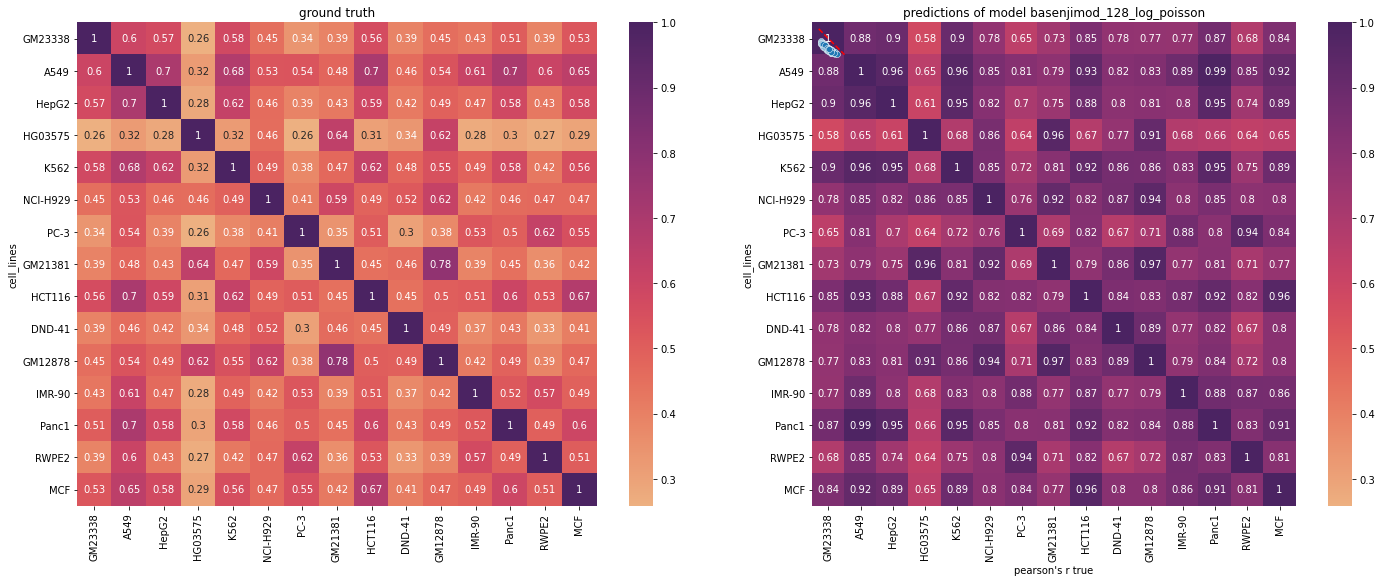

In [147]:
get_corr_dfs_and_plots(run_dirs[0])

In [43]:
per_run_corrs = {}
set_type = 'raw'
for run in run_dirs[:-1]:

#     corr_dfs, model_id = get_corr_df(run, set_type) 
#     per_run_corrs[model_id] = corr_dfs
    corr_dfs = {}
    keys = ['pred', 'truth']
    for c, csv_file in enumerate(['correlation_matrix_pred_128_raw.csv', 'correlation_matrix_truth_128_raw.csv']):
        corr_dfs[keys[c]] = pd.read_csv(os.path.join(run, 'plots_and_tables', csv_file), index_col='cell_lines')
    per_run_corrs[model_id] = corr_dfs

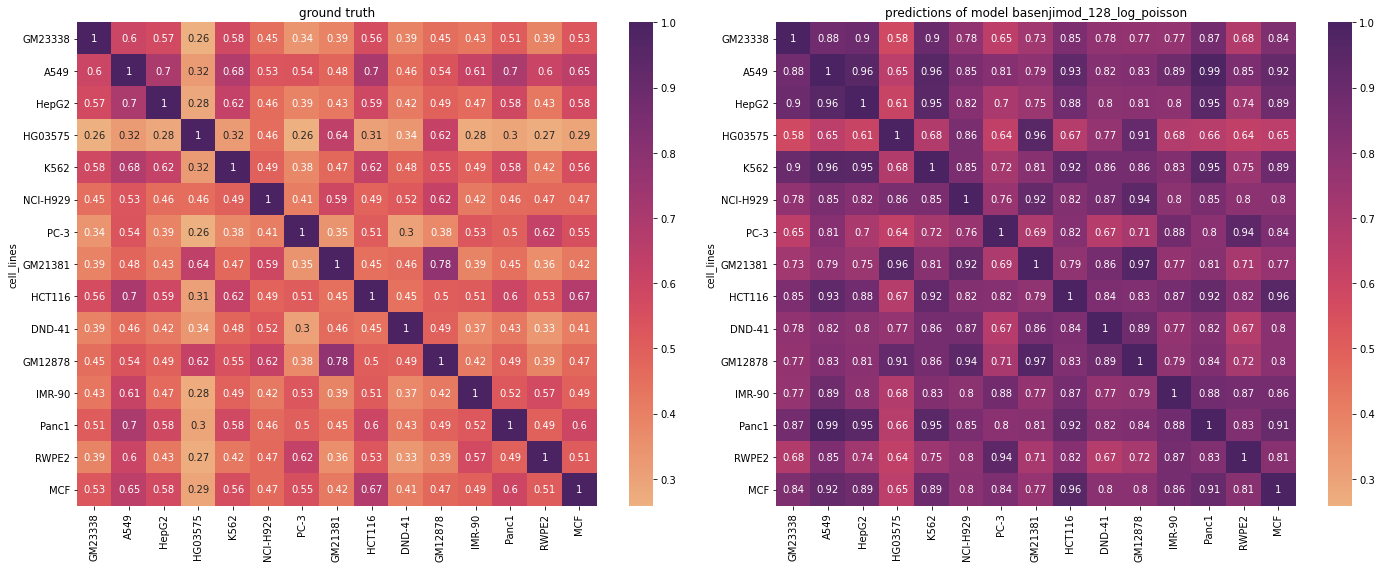

In [64]:
fig, axs = plt.subplots(1, 2, figsize=[20, 8])
for i, (model_id, corr_dfs) in enumerate(per_run_corrs.items()): 
    titles = ['ground truth', 'predictions of model {}'.format(model_id)]
    truth_heatmap = sns.heatmap(corr_dfs['truth'], annot=True, vmin=min_lim, vmax=1,  ax=axs[0], cmap='flare')
    axs[0].set_title(titles[0])
    pred_heatmap = sns.heatmap(corr_dfs['pred'], annot=True, vmin=min_lim, vmax=1, ax=axs[1], cmap='flare')
    axs[1].set_title(titles[1])

plt.tight_layout()
plt.savefig('testfig.svg')

In [101]:
corr_df = melted_corrs['truth'].merge(melted_corrs['pred'], on=['cell_line1', 'cell_line2'], suffixes=[' true', ' pred'])

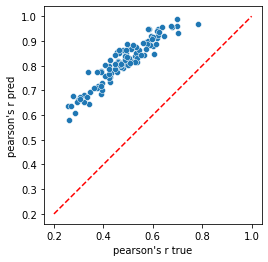

In [139]:
plt.plot(figsize=[20, 20])
ax = sns.scatterplot(data=corr_df, x='pearson\'s r true', y='pearson\'s r pred')
x = [i/10 for i in range(2, 11)]
plt.plot(x, x, 'r--')
ax.set_aspect(1./ax.get_data_ratio())